# Image search engine with DocArray

In this notebook, we use [DocArray](https://docarray.jina.ai/) to show how you can set up a simple similar image search. 

## 1. Importing libraries

In [2]:
from docarray import Document, DocumentArray

## 2. Configuration and setup

We'll set up some basic variables. Feel free to adapt these for your own project!

There is some sample data included in this repository.

The images in the sample dataset are already scaled down to 80x60 to limit the file size.

In [17]:
MAX_DOCS = 10000
DATA_DIR = '../images/fashion/'
DATA_PATH = f"{DATA_DIR}/**/*.jpg"
QUERY_IMAGE = "../images/fashion/012/0120129025.jpg"

DocArray supports Elasticsearch as a storage backend, one can use it as the follows:

In [40]:
DocumentArray(
    storage='elasticsearch',
    config={'hosts': 'http://es01:9200','index_name': 'image_search','n_dim': 1000},
).summary()

╭─────────────── Documents Summary ───────────────╮
│                                                 │
│   Type                   DocumentArrayElastic   │
│   Length                 0                      │
│   Homogenous Documents   False                  │
│   Multimodal dataclass   True                   │
│                                                 │
╰─────────────────────────────────────────────────╯
╭───── DocumentArrayElastic Config ──────╮
│                                        │
│   n_dim             1000               │
│   distance          cosine             │
│   hosts             http://es01:9200   │
│   index_name        image_search       │
│   list_like         True               │
│   es_config         {}                 │
│   index_text        False              │
│   tag_indices       []                 │
│   batch_size        64                 │
│   ef_construction   None               │
│   m                 None               │
│   columns           {}                 │
│   root_id           True               │
│                                        │
╰────────────────────────────────────────╯

The look-and-feel of a weaviate-powered DocumentArray is exactly the same as an ordinary DocumentArray. All APIs behave the same. We will see that in the sequel.

## 3. Load Data

Now that all is set up, we can start adding the fashion images to the database. 

In [41]:
docs = DocumentArray.from_files(
    DATA_PATH,
    size=MAX_DOCS,
    storage='elasticsearch',
    config={'hosts': 'http://es01:9200','index_name': 'image_search','n_dim': 1000},
)

print(f"{len(docs)} Documents in DocumentArray")


1000 Documents in DocumentArray


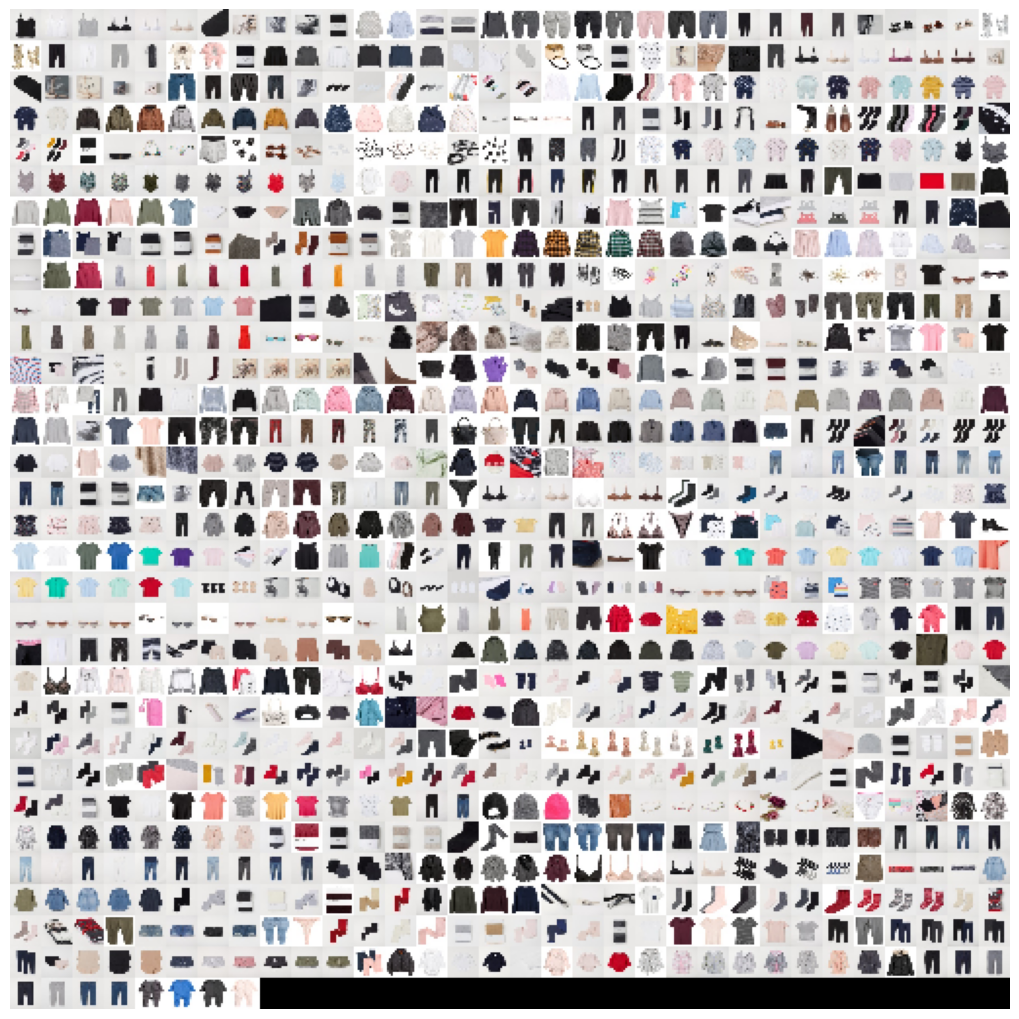

In [42]:
docs.plot_image_sprites() # Preview the images

## 4. Preprocess Data

In [43]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [44]:
# apply en masse
docs.apply(preproc)

╭─────────────────────── Documents Summary ───────────────────────╮
│                                                                 │
│   Type                   DocumentArrayElastic                   │
│   Length                 1000                                   │
│   Homogenous Documents   True                                   │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri')   │
│   Multimodal dataclass   False                                  │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   id          ('str',)       1000             False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   1000             False             │
│   uri         ('str',)       1000             False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭───── DocumentArrayElastic Config ──────╮
│                                        │
│   n_dim             1000               │
│   distance          cosine             │
│   hosts             http://es01:9200   │
│   index_name        image_search       │
│   list_like         True               │
│   es_config         {}                 │
│   index_text        False              │
│   tag_indices       []                 │
│   batch_size        64                 │
│   ef_construction   None               │
│   m                 None               │
│   columns           {}                 │
│   root_id           True               │
│                                        │
╰────────────────────────────────────────╯

## 5. Embed images

Using GPU is recommended when you want to do image search on large scale. 

In [45]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cpu


We use the ResNet50 model to embed our images. 

In [46]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [47]:
docs.embed(model, device=device, batch_size=20)

╭───────────────────────────── Documents Summary ──────────────────────────────╮
│                                                                              │
│   Type                   DocumentArrayElastic                                │
│   Length                 1000                                                │
│   Homogenous Documents   True                                                │
│   Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')   │
│   Multimodal dataclass   False                                               │
│                                                                              │
╰──────────────────────────────────────────────────────────────────────────────╯
╭────────────────────── Attributes Summary ───────────────────────╮
│                                                                 │
│   Attribute   Data type      #Unique values   Has empty value   │
│  ─────────────────────────────────────────────────────────────  │
│   embedding   ('Tensor',)    1000             False             │
│   id          ('str',)       1000             False             │
│   mime_type   ('str',)       1                False             │
│   tensor      ('ndarray',)   1000             False             │
│   uri         ('str',)       1000             False             │
│                                                                 │
╰─────────────────────────────────────────────────────────────────╯
╭───── DocumentArrayElastic Config ──────╮
│                                        │
│   n_dim             1000               │
│   distance          cosine             │
│   hosts             http://es01:9200   │
│   index_name        image_search       │
│   list_like         True               │
│   es_config         {}                 │
│   index_text        False              │
│   tag_indices       []                 │
│   batch_size        64                 │
│   ef_construction   None               │
│   m                 None               │
│   columns           {}                 │
│   root_id           True               │
│                                        │
╰────────────────────────────────────────╯

We can remove the tensor of the images to reduce remory usage. This will significantly improve the speed of the `.find()` operation below.

In [48]:
docs[:, 'tensor'] = None

## 6. Query dataset

Let's query the dataset with one of the images of the dataset. We've stored this in `data/query.jpg`. Feel free to choose any jpg image of clothing as query image.

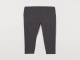

In [49]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [50]:
query_doc = preproc(query_doc)

In [51]:
query_doc.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

📄 Document: 366cdd18ff260c18650a24ceccee78c8
╭────────────┬─────────────────────────────────────────────────────────────────╮
│ Attribute  │ Value                                                           │
├────────────┼─────────────────────────────────────────────────────────────────┤
│ tensor     │ <class 'numpy.ndarray'> in shape (3, 80, 60), dtype: float32    │
│ mime_type  │ image/jpeg                                                      │
│ uri        │ ../images/fashion/012/0120129025.jpg                            │
│ embedding  │ <class 'torch.Tensor'> in shape (1000,), dtype: float32         │
╰────────────┴─────────────────────────────────────────────────────────────────╯

In [52]:
top10 = docs.find(query_doc, limit=10)

print(top10)

[<DocumentArray (length=10) at 281471547490368>]


/home/vscode/.local/lib/python3.10/site-packages/docarray/array/storage/elastic/find.py:65: ElasticsearchWarning: The kNN search API has been replaced by the `knn` option in the search API.
  resp = self._client.knn_search(


Show the result:

In [53]:
top10.plot_image_sprites(image_source='uri')

AttributeError: 'list' object has no attribute 'plot_image_sprites'

That's it! You can change the example query image and try out more searches yourself.